## Import Data

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data = pd.read_csv("spam_text.csv")
data.head()

Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


## TF-IDF Vectorization

In [4]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data['Message'])
tfidf_matrix.shape

(5572, 8709)

There are 8709 features in our data.

## Sets Spliting

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = tfidf_matrix
y = data['Category'].apply(lambda x: 1 if x == 'spam' else 0)  # Convert 'ham'/'spam' to 0/1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Chi-squared feature selection (k=3000), trained by Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'max_features': 'sqrt', 'n_estimators': 10} has a mean score of 0.969 with a std deviation of 0.008
{'max_features': 'sqrt', 'n_estimators': 20} has a mean score of 0.972 with a std deviation of 0.006
{'max_features': 'sqrt', 'n_estimators': 30} has a mean score of 0.972 with a std deviation of 0.008
{'max_features': 'sqrt', 'n_estimators': 40} has a mean score of 0.973 with a std deviation of 0.006
{'max_features': 'sqrt', 'n_estimators': 50} has a mean score of 0.974 with a std deviation of 0.005
{'max_features': 'sqrt', 'n_estimators': 60} has a mean score of 0.977 with a std deviation of 0.006
{'max_features': 'sqrt', 'n_estimators': 70} has a mean score of 0.974 with a std deviation of 0.007
{'max_features': 'sqrt', 'n_estimators': 80} has a mean score of 0.975 with a std deviation of 0.005
{'max_features': 'sqrt', 'n_estimators': 90} has a mean score of 0.975 with a std deviation of 0.006
{'max_features': 'sqrt', 'n_e

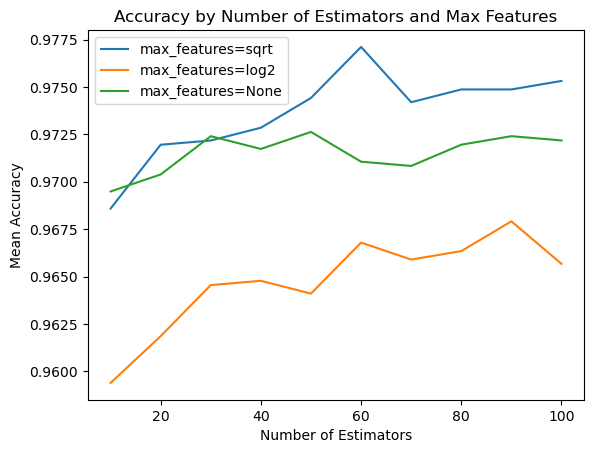

In [57]:
# Chi-squared
ch2 = SelectKBest(chi2, k=3000)
chi2_selector = SelectKBest(chi2, k=3000)
X_train_rf_chi2 = ch2.fit_transform(X_train, y_train)
X_test_rf_chi2 = ch2.transform(X_test)
rf_classifier = RandomForestClassifier()
param_grid = {
    'n_estimators': range(10, 101, 10),
    'max_features': ['sqrt', 'log2', None]
}
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_rf_chi2, y_train)
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

for mean, stdev, param in zip(mean_scores, std_scores, params):
    print(f"{param} has a mean score of {mean:.3f} with a std deviation of {stdev:.3f}")

scores_matrix = mean_scores.reshape(len(param_grid['max_features']), len(param_grid['n_estimators']))
for i, max_feature in enumerate(param_grid['max_features']):
    plt.plot(param_grid['n_estimators'], scores_matrix[i, :], label=f'max_features={max_feature}')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy by Number of Estimators and Max Features')
plt.legend()
plt.show()

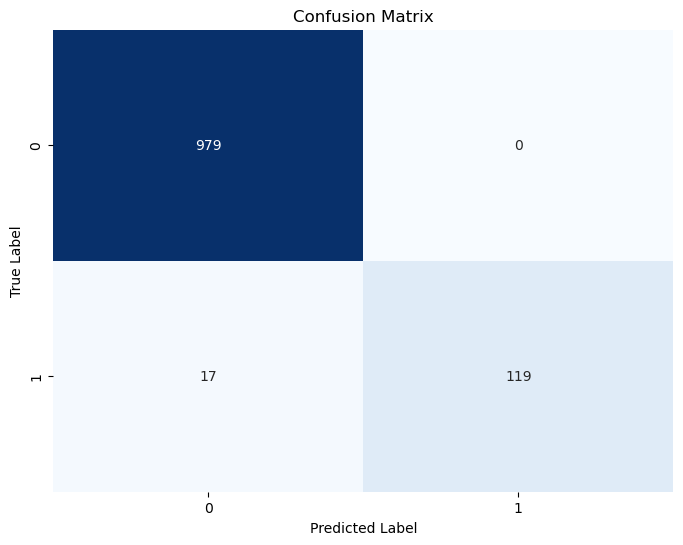

({'max_features': 'sqrt', 'n_estimators': 60}, 1.0, 0.875)

In [58]:
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_rf_chi2)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
best_params, precision, recall

In [59]:
# Mutual Info
mi_selector = SelectKBest(mutual_info_classif, k=3000)
X_train_rf_mi = mi_selector.fit_transform(X_train, y_train)
X_test_rf_mi = mi_selector.transform(X_test)

grid_search.fit(X_train_rf_mi, y_train)
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_rf_mi)
precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
best_params, precision, recall

/Users/danieldu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/danieldu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/danieldu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/danieldu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary valu

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/danieldu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/danieldu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/danieldu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/danieldu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary valu

({'max_features': 'sqrt', 'n_estimators': 40}, 1.0, 0.8602941176470589)

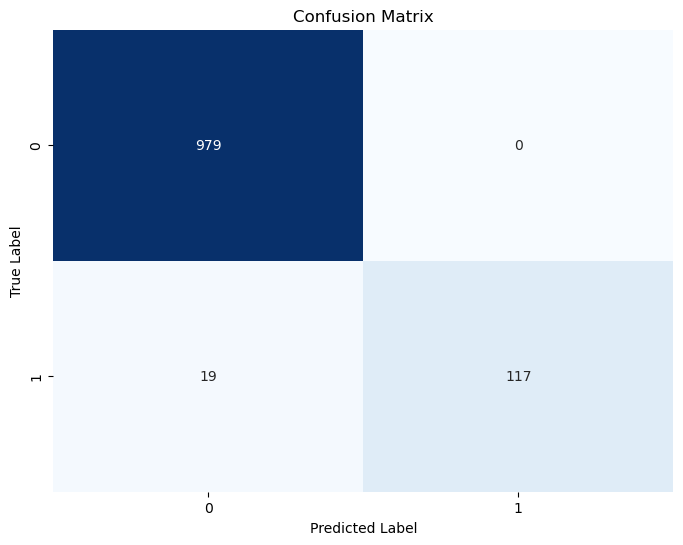

In [60]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [62]:
from sklearn.naive_bayes import MultinomialNB

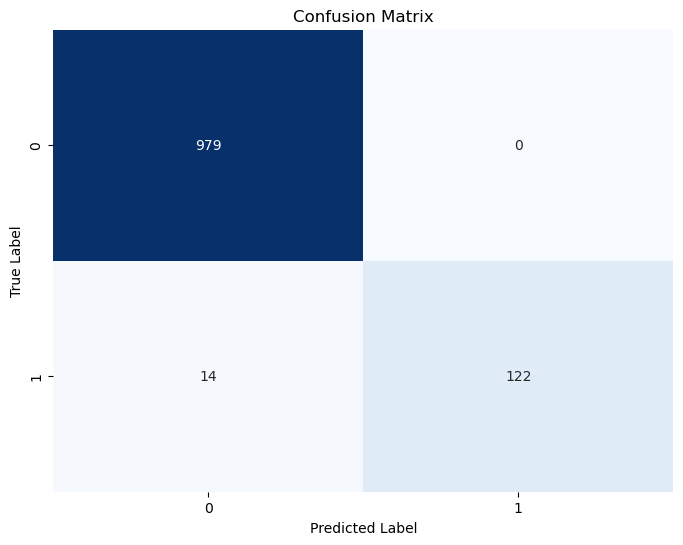

(MultinomialNB(alpha=0.1), 1.0, 0.8970588235294118)

In [65]:
chi2_selector = SelectKBest(chi2, k=3000)
X_train_k = chi2_selector.fit_transform(X_train, y_train)
X_test_k = chi2_selector.transform(X_test)
nb_classifier = MultinomialNB()
param_grid = {'alpha': [0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_k, y_train)
best_nb = grid_search.best_estimator_
y_pred = best_nb.predict(X_test_k)
precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
best_nb, precision, recall

## Mutual information feature selection trained by Naive Bayes

In [66]:
# Mutual information (k=3000)
mi_selector_3 = SelectKBest(mutual_info_classif, k=3000)
X_train_mi_3 = mi_selector_3.fit_transform(X_train, y_train)
X_test_mi_3 = mi_selector_3.transform(X_test)
X_train_mi_3.shape, X_test_mi_3.shape

/Users/danieldu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/danieldu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/danieldu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/danieldu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary valu

((4457, 3000), (1115, 3000))

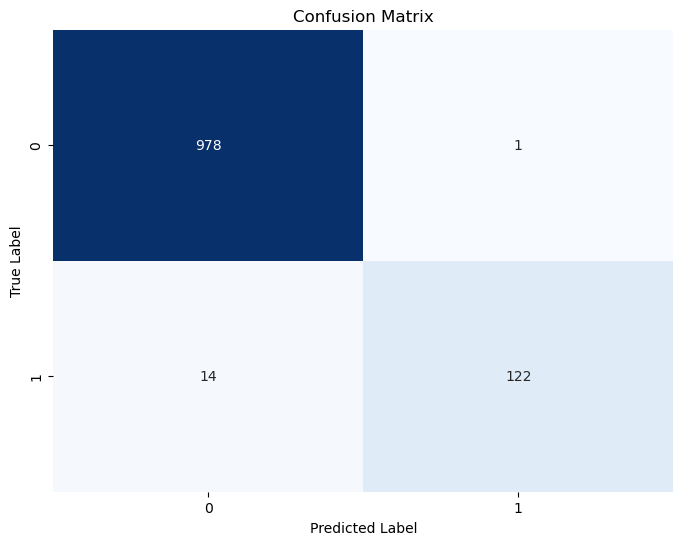

(MultinomialNB(alpha=0.1), 0.991869918699187, 0.8970588235294118)

In [67]:
grid_search.fit(X_train_mi_3, y_train)
best_nb = grid_search.best_estimator_
y_pred = best_nb.predict(X_test_mi_3)
precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
best_nb, precision, recall